In [1]:
import warnings                              # This block prevents display of harmless warnings, but should be
warnings.filterwarnings('ignore')            # commented out till the experiment final version,
                                             # in order to avoid missing "real" warnings 

import kilroy_was_here                       # Mandatory. Allow access to shared python code from repository root
from audace.jupytools import predestination  # Global Random seed for reproducibilty.
from audace.audiodataset import AudioDataset # Main class for audio dataset handling


# Let's seed the various PRNGs, for reproducibility,
# using de default seed.
#
# Note1: this cannot apply to SQLite Random() function,
#       so its use is forbidden. e.g ORDER BY RANDOM()
#       should not be used in an sql query.
#
# Note2: repeated execution of a any cell requiring
#        randomness WILL NOT give the same result unless
#        predestination invocation was done from this cell
predestination()

# Dataset name is the master key for dataset adressing
# Changing according to the dataset you want to process
DATASET_NAME = 'MAIN1000'

# Initialize Dataset Object. 
ds = AudioDataset(DATASET_NAME)
    
# Display AudioDataset summary    
ds.info()

# Get pandas dataframe containing the columns we will need for this experiments
sql = "select mfcc20, queen from samples where nobee = 0"
df = ds.queryDataFrame(sql)



[2020-08-18/21:26:53.594|28.5%|50.7%|0.26GB] ------------------------------------------------------
[2020-08-18/21:26:53.594|00.0%|50.7%|0.26GB] DATASET NAME          : MAIN1000
[2020-08-18/21:26:53.610|37.5%|50.7%|0.26GB] DATASET PATH          : D:\Jupyter\ShowBees\datasets\MAIN1000
[2020-08-18/21:26:53.610|00.0%|50.7%|0.26GB] DATASET DB PATH       : D:\Jupyter\ShowBees\datasets\MAIN1000\MAIN1000.db
[2020-08-18/21:26:53.610|00.0%|50.7%|0.26GB] DATASET SAMPLES PATH  : D:\Jupyter\ShowBees\datasets\MAIN1000\samples
[2020-08-18/21:26:53.610|00.0%|50.7%|0.26GB] NB SOURCE AUDIO FILES : 48
[2020-08-18/21:26:53.610|00.0%|50.7%|0.26GB] SAMPLE RATE           : 22050
[2020-08-18/21:26:53.610|00.0%|50.7%|0.26GB] DURATION              : 1.0
[2020-08-18/21:26:53.610|00.0%|50.7%|0.26GB] OVERLAP               : 0.0
[2020-08-18/21:26:53.610|00.0%|50.7%|0.26GB] NB AUDIO CHUNKS       : 24788
[2020-08-18/21:26:53.610|00.0%|50.7%|0.26GB] ------------------------------------------------------


In [6]:
print(df['mfcc20'].shape)
print(df['mfcc20'][0].shape)
print(df['mfcc20'].to_numpy().shape)


(17205,)
(20, 44)
(17205,)


In [3]:
from sklearn.model_selection import train_test_split
# Seed the various PRNGs
predestination()

FEATURE_NAME = 'mfcc20'

features = []
for v in df[FEATURE_NAME]:
    features.append(v.flatten().tolist())

TEST_FRAC = 0.3

X_train, X_test, y_train, y_test = train_test_split(features, df['queen'], test_size=TEST_FRAC)

In [4]:
from sklearn import svm
from sklearn import metrics

# Seed the various PRNGs
predestination()

KERNEL='rbf'



#Create a svm Classifier
clf = svm.SVC(kernel=KERNEL)

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)


print("train", y_train.shape)
print("pred", y_pred.shape)
print("test", y_test.shape)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("F1:",metrics.f1_score(y_test, y_pred))


train (12043,)
pred (5162,)
test (5162,)
Accuracy: 0.9029445951181713
Precision: 0.9515845070422535
Recall: 0.8468468468468469
F1: 0.8961658031088083


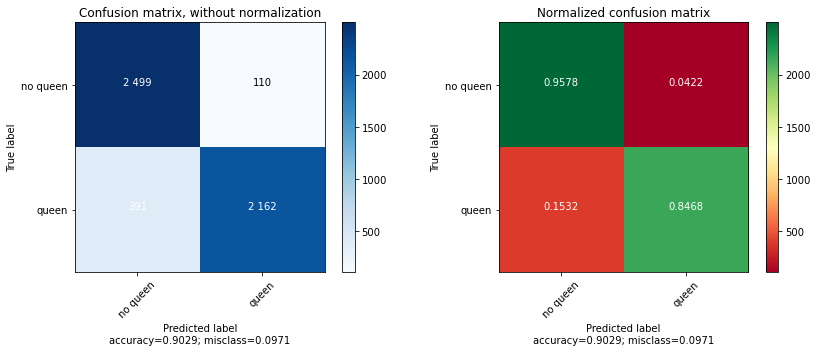




              precision    recall  f1-score   support

    no queen       0.86      0.96      0.91      2609
       queen       0.95      0.85      0.90      2553

    accuracy                           0.90      5162
   macro avg       0.91      0.90      0.90      5162
weighted avg       0.91      0.90      0.90      5162



In [6]:
import matplotlib.pyplot as plt
from audace.plotters import plot_confusion_matrix, save_fig
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

target_names=['no queen', 'queen']

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred )


ROWS=1
plt.figure(figsize=(12, 5))

plt.subplot(121)
# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, target_names=target_names, normalize=False,
                      title='Confusion matrix, without normalization')

plt.subplot(122)
# Plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix, target_names=target_names, normalize=True,
                      title='Normalized confusion matrix', cmap=plt.cm.RdYlGn)

plt.tight_layout()
save_fig("03 - SVM Confusion Matrices")
plt.show()

print("\n\n")
print(classification_report(y_test, y_pred , target_names=target_names))



In [ ]:
from sklearn.metrics import roc_curve
from audace.plotters import plot_roc_curve
from sklearn.metrics import roc_auc_score

y_scores = clf.decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_scores)

plt.figure(figsize=(8, 6))

plt.plot(fpr, tpr, linewidth=2, label='urg')
plot_roc_curve(fpr, tpr)
plt.show()


print('AUC', roc_auc_score(y_test, y_scores))

In [49]:
df1 = ds.queryDataFrame("select magic05, apidictor, mfcc20, queen from samples where nobee = 0 and hive = 'Hive1'")
df3 = ds.queryDataFrame("select magic05, apidictor, mfcc20, queen from samples where nobee = 0 and hive = 'Hive3'")

FEATURE_NAME = 'mfcc20'
KERNEL='rbf'

X1 = []
for v in df1[FEATURE_NAME]:
    X1.append(v.flatten().tolist())

y1 = df1['queen']
    
    
X3 = []
for v in df3[FEATURE_NAME]:
    X3.append(v.flatten().tolist())
    
y3 = df3['queen']
    

#Create a svm Classifier
clf1 = svm.SVC(kernel=KERNEL)

#Train the model using the training sets
clf1.fit(X1, y1)

#Predict the response for test dataset
y3_pred = clf1.predict(X3)
    

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

print("Accuracy:",metrics.accuracy_score(y3, y3_pred))
print("Precision:",metrics.precision_score(y3, y3_pred))
print("Recall:",metrics.recall_score(y3, y3_pred))
print("F1:",metrics.f1_score(y3, y3_pred))


#Create a svm Classifier
clf3 = svm.SVC(kernel=KERNEL)

#Train the model using the training sets
clf3.fit(X3, y3)

#Predict the response for test dataset
y1_pred = clf3.predict(X1)



print("Accuracy:",metrics.accuracy_score(y1, y1_pred))
print("Precision:",metrics.precision_score(y1, y1_pred))
print("Recall:",metrics.recall_score(y1, y1_pred))
print("F1:",metrics.f1_score(y1, y1_pred))

Accuracy: 0.5528734055685092
Precision: 0.22807017543859648
Recall: 0.016581632653061226
F1: 0.030915576694411417
Accuracy: 0.4708235294117647
Precision: 0.28599033816425123
Recall: 0.07299630086313194
F1: 0.1163064833005894
